# Using Numba to Solve All the Same Equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from numba import njit

In [2]:
N = 200
M = 200
T = 100
t0 = 1

u_1 = np.empty([M,N])
u_2 = np.empty([M,N])

@njit                # initialization does not take much time
def init(U1, U2):    # but we use it in the function decorated with njit
    U1[0,:] = t0     # so it should be jitted
    U2[0,:] = t0
    
    U1[1:,:] = 0.
    U2[1:,:] = 0.

In [3]:
def step(U1, U2):
    for i in np.arange(1,M-1):
        for j in np.arange(1, N-1):
            U2[i, j] = U1[i+1, j] + U1[i-1, j] \
                     + U1[i, j+1] + U1[i, j-1]
            
            U2[i, j] *= .25

In [4]:
def evolve(U1, U2, step_f, n_steps): # step_f here is used just for 
                                     # the results comparison
    init(U1, U2)
    count = 0
    while count < n_steps:
        step_f(U1, U2)
        step_f(U2, U1)
        count += 2

In [5]:
kernel = np.empty((3,3), dtype=int)
kernel[0] = 0, 1, 0
kernel[1] = 1, 0, 1
kernel[2] = 0, 1, 0

In [6]:
def py_evolve(U, n_steps):
    def py_step(U):
        U[1:-1, 1:-1] = convolve2d(U, kernel, 'same')[1:-1, 1:-1]
        U[1:-1, 1:-1] *= .25
    U[0, :] = t0
    U[1:,:] = 0.
    for i in range(n_steps):
        py_step(U)

In [7]:
step_numba = njit()(step)
evolve_numba = njit()(evolve)

In [8]:
plain  = %timeit -o evolve(u_1, u_2, step, T)
python = %timeit -o py_evolve(u_1, T)
jitted = %timeit -o evolve_numba(u_1, u_2, step_numba, T)

6.85 s ± 600 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
125 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
11.9 ms ± 37 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


With numba it is 524.383 faster than pythonized C code
__..__..__..__ And 10.154 faster than its python version


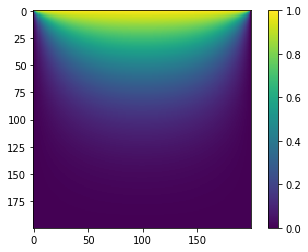

In [9]:
evolve_numba(u_1, u_2, step_numba, 10000)
plt.imshow(u_1)
plt.colorbar()
print("With numba it is %.3f faster than pythonized C code" \
      % (plain.best / jitted.best))
print("__..__..__..__ And %.3f faster than its python version" \
      % (python.best / jitted.best))